In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib import patches

sys.path.append('..')#
from util import add_angles, angle_between, angled_vector, sub_angles, get_rotation_matrix
from calovi import WallModel
from binning import wall_neglible_at, transform_coords_df

In [2]:
R = get_rotation_matrix(np.deg2rad(270))
R @ np.array([1,0])
add_angles(-np.pi, -0.00001)

3.1415826535897935

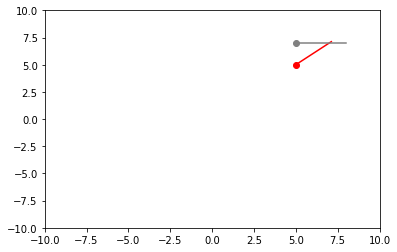

In [3]:
def plot_grid(p1, p2, traj1, traj2):
    fig, ax = plt.subplots()
    ax.scatter(p1[0], p1[1], c='r')
    ax.scatter(p2[0], p2[1], c='gray')

    ax.plot([p1[0], p1[0] + traj1[0]], [p1[1], p1[1] + traj1[1]], c='r')
    ax.plot([p2[0], p2[0] + traj2[0]], [p2[1], p2[1] + traj2[1]], c='gray')

    ax.set_xbound(-10, 10)
    ax.set_ybound(-10, 10)
    

pos1, pos2 = np.array([5,5]), np.array([5,7])
ang1, ang2 = np.deg2rad([45, 0])
traj1, traj2 = angled_vector(ang1) * 3, angled_vector(ang2) * 3

plot_grid(pos1, pos2, traj1, traj2)

(array([ 45.,   0., -45.]),)

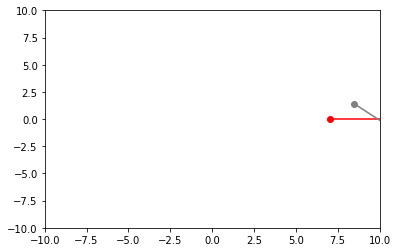

In [4]:
# RF
# 1. Rotate coord system.
R = get_rotation_matrix(-ang1)
pos1_rot = R @ pos1.reshape(2,1)
pos2_rot = R @ pos2.reshape(2,1)
traj1_rot = R @ traj1
traj2_rot = R @ traj2
# 2. Set p1 at center (0,0) and adjust other
#pos2_rot -= pos1_rot
#pos1_rot = np.array([0.0, 0.0])
#ang1_rot = 0.0
ang2_rot = sub_angles(ang2,ang1)
# 3. Plot
plot_grid(pos1_rot, pos2_rot, traj1_rot, traj2_rot)

np.rad2deg(np.array([ang1, ang2, ang2_rot])), 

In [5]:
df_kicks_tr = pd.read_csv('../../data/processed/kicks_guy_train.csv')
df_kicks_te = pd.read_csv('../../data/processed/kicks_guy_test.csv')

In [6]:
import dill as pickle
with open('../calovi_wall.model', mode='rb') as f:
    wall_model = pickle.load(f)
    
cutoff_wall_range = wall_neglible_at(wall_model)
cutoff_wall_range

4.762710318272587

In [7]:
from itertools import product
# Compute relative coords/angles

df_train = transform_coords_df(df_kicks_tr.copy(), cutoff_wall_range=cutoff_wall_range)
df_test = transform_coords_df(df_kicks_te.copy(), cutoff_wall_range=cutoff_wall_range)

In [8]:
lo_x, hi_x = np.percentile(a=df_train['x_f1'], q=[25,75])
lo_y, hi_y = np.percentile(a=df_train['x_f1'], q=[25,75])
iqr_x = hi_x - lo_x
iqr_y = hi_y - lo_y

# Bin range without outliers (using 1.5 IQR)
lower_limit = min(lo_x - 1.5*iqr_x, lo_y - 1.5*iqr_y)
upper_limit = max(hi_x + 1.5*iqr_x, hi_y + 1.5 * iqr_y)

rf_size = max(-lower_limit, upper_limit)
num_bins = 9
b = np.linspace(rf_size, 0, num=num_bins//2, endpoint=False)
bins = np.hstack((-b,[0], b[::-1]))
#np.unique(df_train['bin'], return_counts=True)
bins

array([-4.86913995, -3.65185496, -2.43456998, -1.21728499,  0.        ,
        1.21728499,  2.43456998,  3.65185496,  4.86913995])

In [23]:
def get_bins_static(df, num_bins=7, ignore_outliers=True):
    # Build symmetric receptive field.
    if ignore_outliers:
        lo_x, hi_x = np.percentile(a=df_train['x_f1'], q=[25,75])
        lo_y, hi_y = np.percentile(a=df_train['x_f1'], q=[25,75])
        iqr_x = hi_x - lo_x
        iqr_y = hi_y - lo_y

        # Bin range without outliers (using 1.5 IQR)
        lower_limit = min(lo_x - 1.5*iqr_x, lo_y - 1.5*iqr_y)
        upper_limit = max(hi_x + 1.5*iqr_x, hi_y + 1.5 * iqr_y)

        rf_size = max(-lower_limit, upper_limit)        
    else:
        rf_size = max(df['x_f1'].abs().max(), df['y_f1'].abs().max())
    print(rf_size)
    
    # RF has size rf_size x rf_size, each direction divided by num_bins
    # Should be of form 2n-1 (symmetric in pos/neg. direction, centered at (0,0))
    assert(((num_bins-1) % 2) == 0)
    
    b = np.linspace(rf_size, 0, num=num_bins//2, endpoint=False)
    #b = np.array([rf_size/(i+1) for i in range(num_bins//2)])
    bins = np.hstack((-b,[0], b[::-1]))
    
    return bins

num_bins = 5
bins = get_bins_static(df_train, num_bins)
def digitize_df_static(df, bins, closed_interval=True):
    # TODO: Open intervals on both sides!
    bin_x = np.digitize(df['x_f1'], bins=bins) - 1
    bin_y = np.digitize(df['y_f1'], bins=bins) - 1
    
    # Clip to range
    bin_x = bin_x.clip(0, num_bins-1)
    bin_y = bin_y.clip(0, num_bins-1)
    
    bin = (bin_x*len(bins)) + bin_y
    if closed_interval:
        # Fish outside range have bin -1
        bin[(df['x_f1'] <= bins.min()) | (df['y_f1'] <= bins.min()) |
           (df['x_f1'] >= bins.max()) | (df['y_f1'] >= bins.max())] = -1
    
    return bin

df_train['bin'] = pd.Series(digitize_df_static(df_train, bins), index=df_train.index)
df_test['bin'] = pd.Series(digitize_df_static(df_test, bins), index=df_test.index)

np.unique(df_train['bin'], return_counts=True)[1]
#bins.min(), bins.max(
#df_train['bin'].max()

4.869139953267856


4301

3622.609375 322.36865625725676 3089
815.890625 233.28584378849345 329
4152 3089
63 63


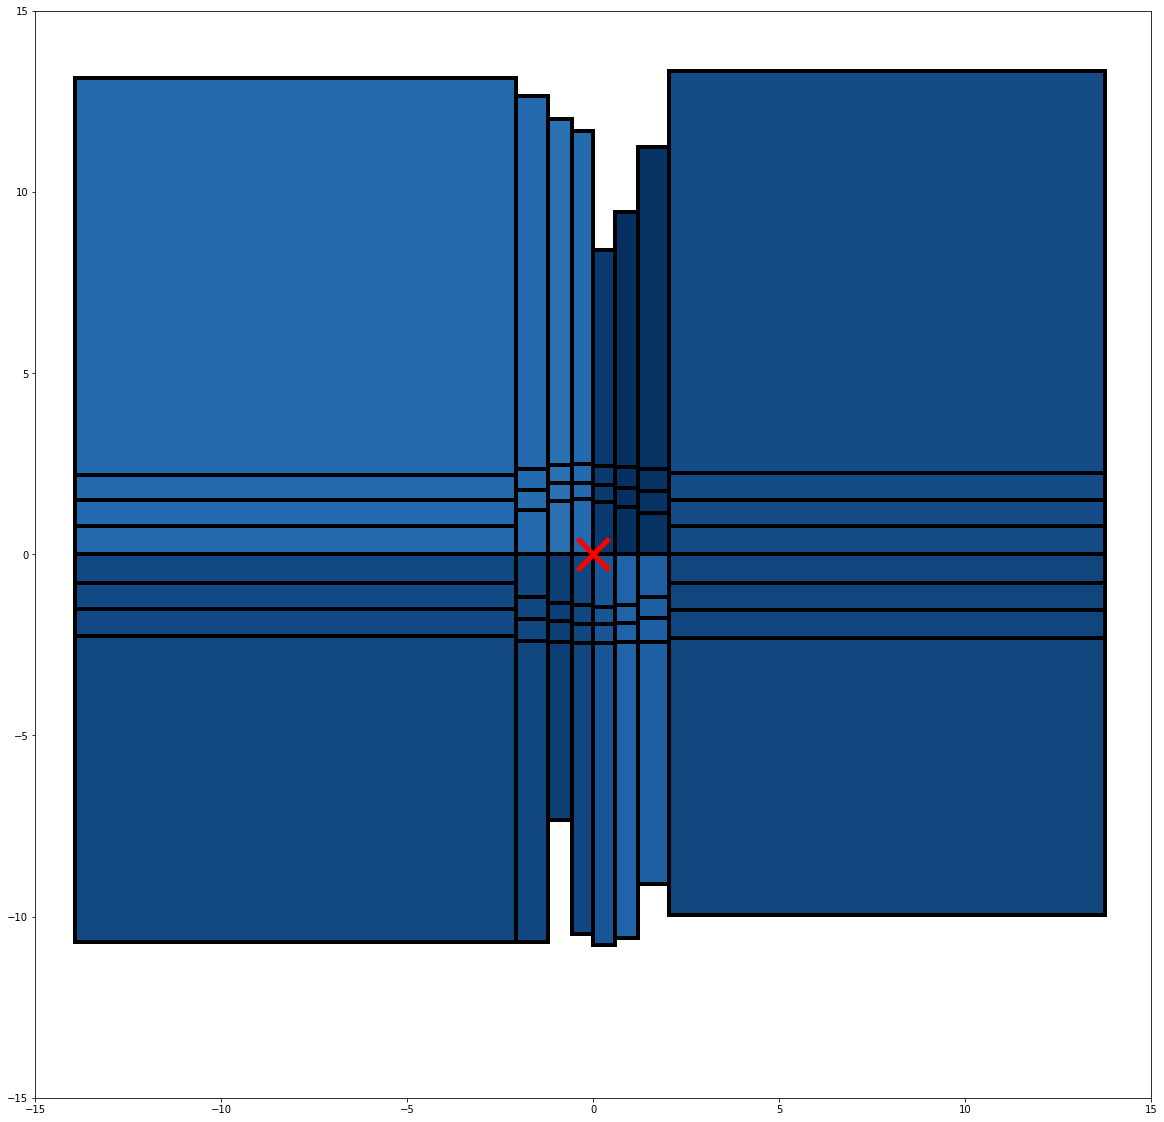

In [24]:
def bin_one_dim(array, num_bins):
# Inspired by np.array_split
# https://github.com/numpy/numpy/blob/v1.14.0/numpy/lib/shape_base.py#L431-L483
# Divide into equal bins, if not possible first few bins have size + 1
    
    a = np.sort(array)
    assert(np.signbit(a[0]) == np.signbit(a[-1]))
    num_per_bin, extras = divmod(len(a), num_bins)
    section_sizes = [0] + extras * [num_per_bin+1] + (num_bins-extras) * [num_per_bin]
    div_ind = np.array(section_sizes).cumsum()
    div_ind[-1] -= 1
    div_ind, len(a)
    bin_edges = a[div_ind]
    if (np.signbit(a[0])):
        bin_edges[-1] = 0.0
    else:
        bin_edges[0] = 0.0
    return bin_edges

# Try without symmetry
def bin_axis(array, num_bins):
    assert(num_bins % 2 == 0)
    #num_bins += 1
    dist_pos = array[array >= 0]
    dist_neg = array[array < 0]
    edges_pos = bin_one_dim(dist_pos, num_bins//2)
    edges_neg = bin_one_dim(dist_neg, num_bins//2)#[::-1]
    edges = np.hstack((edges_neg, edges_pos[1:]))
    
    # Fix empty bins on either side (make bit larger than data range)
    eps = 10e-6
    edges[0] -= eps
    edges[-1] += eps
    return edges

def bin_df(df, num_bins=6):
    edges_x = bin_axis(df['x_f1'].values, num_bins)
    bins_x = np.digitize(df['x_f1'].values, edges_x, right=False) - 1
    #bins_y = np.zeros_like(bins_x) - 1 # invalid bins for now!

    edges_y = np.zeros((num_bins, num_bins+1))

    for i in range(num_bins):
        is_in_bin = bins_x == i
        cur_y = df.loc[is_in_bin,'y_f1'].values
        cur_edges_y = bin_axis(cur_y, num_bins)
        edges_y[i,:] = cur_edges_y
        #cur_bins_y = np.digitize(df.loc[is_in_bin, 'y_f1'].values, cur_edges_y, right=False) - 1
        #bins_y[is_in_bin] = cur_bins_y

    #bins = (bins_x*num_bins) + bins_y
    #df.loc[:,'bin'] = pd.Series(bins, index=df.index)

    return edges_x, edges_y

def get_bins_df(df, edges_x, edges_y):
    bins_x = np.digitize(df['x_f1'].values, edges_x, right=False) - 1
    bins_x = bins_x.clip(0, len(edges_x) - 2) # todo
    bins_y = np.zeros_like(bins_x) - 1 # invalid bins for now!

    for i in range(num_bins):
        is_in_bin = bins_x == i
        #cur_y = df.loc[is_in_bin,'y_f1'].values
        #cur_edges_y = bin_axis(cur_y, num_bins)
        #edges_y[i,:] = cur_edges_y
        cur_bins_y = np.digitize(df.loc[is_in_bin, 'y_f1'].values,
                                 edges_y[i,:],
                                 right=False) - 1
        cur_bins_y = cur_bins_y.clip(0, len(edges_x) - 2) # todo
        bins_y[is_in_bin] = cur_bins_y

    bins = (bins_x*num_bins) + bins_y
    df.loc[:,'bin'] = pd.Series(bins, index=df.index)    
    
    print(np.unique(bins,return_counts=True)[1].mean(), np.unique(bins,return_counts=True)[1].std(),
         np.unique(bins,return_counts=True)[1].min())

    return df

num_bins=8
edges_x, edges_y = bin_df(df_train, num_bins=num_bins)
df_train = get_bins_df(df_train, edges_x=edges_x, edges_y=edges_y)
df_test = get_bins_df(df_test, edges_x=edges_x, edges_y=edges_y)

from matplotlib import cm
from matplotlib.colors import Normalize

# See: https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib/20146989#20146989
class DivergentNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, clip=False):
        Normalize.__init__(self, vmin, vmax, clip)
        print(self.vmax, self.vmin)
        
    def __call__(self, value, clip=None):
        x, y = [self.vmin, 0.0, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_bins(edges_x, edges_y, weights=None, weights_range=None, fig=None, ax=None):
    nun_bins = len(edges_x) - 1
    edge_x_sizes = np.ediff1d(edges_x)

    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(20,20))        
    
    if weights is None:
        color = lambda x: 'white'
    else:
        if weights_range is None:
            vmin, vmax = weights.min(), weights.max()
        else:
            vmin, vmax = weights_range
        norm = DivergentNormalize(vmin=vmin, vmax=vmax)
        mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdBu)
        mapper.set_array(weights)
        def color(x):
            w = weights[x]
            return mapper.to_rgba(w)
        
    for i, edge_x in enumerate(edges_x[:-1]):
        cur_y_edges = edges_y[i, :]
        cur_edge_y_sizes = np.ediff1d(cur_y_edges)    
        for j, edge_y in enumerate(cur_y_edges[:-1]):
            ax.add_patch(
                patches.Rectangle(
                (edge_x, edge_y),
                edge_x_sizes[i],
                cur_edge_y_sizes[j],
                fill=True,
                facecolor=color(i*num_bins + j),
                edgecolor='black',
                linewidth=4))

    # TODO: Don't hardcore!
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)

    ax.scatter(0,0, c='red', s=1000, marker='x', zorder=10, linewidth=5)
    #ax.axis('off')
    
    if weights is not None:
        return mapper # for colorbar
    #if weights is not None:
    #    ax.colorbar(mapper)    

plot_bins(edges_x, edges_y, weights=np.unique(df_train['bin'], return_counts=True)[1])
print(df_train['bin'].max(), df_test['bin'].max())

In [54]:
import sklearn.preprocessing as pre

def get_Xy(df, num_bins, force_empty_bins=True):
    assert(force_empty_bins)
    # Scale angle:
    #angle_scaler = pre.StandardScaler()
    #angle_scaled = angle_scaler.fit_transform(X=df['angle_f1'].values.reshape(-1,1)).reshape(-1)
    #print(angle_scaled.max(), angle_scaled.mean(), angle_scaled.var())

    # Now we need to one-hot enccode our data.
    # We need one column per variable and bin

    # Indicator for position
    # We need this because some bins could be unoccupied in training but occupied in testing!
    one_hot_enc = pre.OneHotEncoder()
    one_hot_enc.fit(np.array(list(range(0,num_bins**2))).reshape(-1,1))
    
    position_one_hot = one_hot_enc.transform(df.loc[0:, 'bin'].values.reshape(-1,1)).toarray()
    
    #position_one_hot = pd.get_dummies(df['bin'])
    # Mean of angle for bin
    #angle_one_hot = pd.get_dummies(df['bin']).values * angle_scaled[:, None]
    #angle_one_hot = position_one_hot * angle_scaled[:, None]
    
    direction_f0_x = df['trajectory_f1_x'].values.reshape(-1, 1)
    direction_f0_x = position_one_hot * direction_f0_x
    
    direction_f0_y = df['trajectory_f1_y'].values.reshape(-1, 1)
    direction_f0_y = position_one_hot * direction_f0_y

    dts =  df['dt'].values.reshape(-1, 1)

    X = np.concatenate((dts, position_one_hot, direction_f0_x, direction_f0_y), axis=1)
    #X = position_one_hot.values
    y = np.vstack((df['trajectory_f0_x'].values.T, df['trajectory_f0_y'].values.T)).T
    return X, y

print(df_train.columns)
X_np, y_np = get_Xy(df_train, num_bins=num_bins)
X_np_test, y_np_test = get_Xy(df_test, num_bins=num_bins)

y_np =  y_np[df_train['dt'] == 0] # heading change at kick
y_np_test =  y_np_test[df_test['dt'] == 0] # heading change at kick

print(X_np.shape, X_np_test.shape)

# Save to csv
def save_csv(X, y, file_name=None):
    num_dts = X.shape[0]//y.shape[0]
    print(num_dts)
    print(y.shape)
    y = np.repeat(y, num_dts, axis=0)
    print(X.shape, y.shape)
    proccessed_df = pd.DataFrame(np.vstack((X.T, y.T)).T)
    cols = ['dt'] + [f'feature_{i}' for i in range(0, X.shape[1] - 1)] + ['y_0', 'y_1']
    proccessed_df.columns = cols
    proccessed_df.to_csv(file_name, index=None)
save_csv(X_np, y_np, '../../data/processed/rf_train.csv')
save_csv(X_np_test, y_np_test, '../../data/processed/rf_test.csv')

#get_Xy(df_test, num_bins=num_bins)[1].shape

Index(['dt', 'trajectory_f0_x', 'trajectory_f0_y', 'x_f1', 'y_f1',
       'trajectory_f1_x', 'trajectory_f1_y', 'bin'],
      dtype='object')
(231847, 193) (52217, 193)
11
(21077, 2)
(231847, 193) (231847, 2)
11
(4747, 2)
(52217, 193) (52217, 2)


In [55]:
import sklearn.linear_model as lm
# drop all rows that contain past information and drop dt column
X = X_np[df_train['dt']==0, 1:]
linear = lm.RidgeCV(alphas=np.logspace(-3, 5, num=32))
linear = linear.fit(X,y_np)
linear.score(X, y_np)

0.19114240727969004

In [56]:
linear.coef_.shape, linear.intercept_, X_np.shape

((2, 192), array([1.09244788, 0.01036048]), (231847, 193))

0.6294544358472838 -0.5942466370839432
0.6294544358472838 -0.5942466370839432


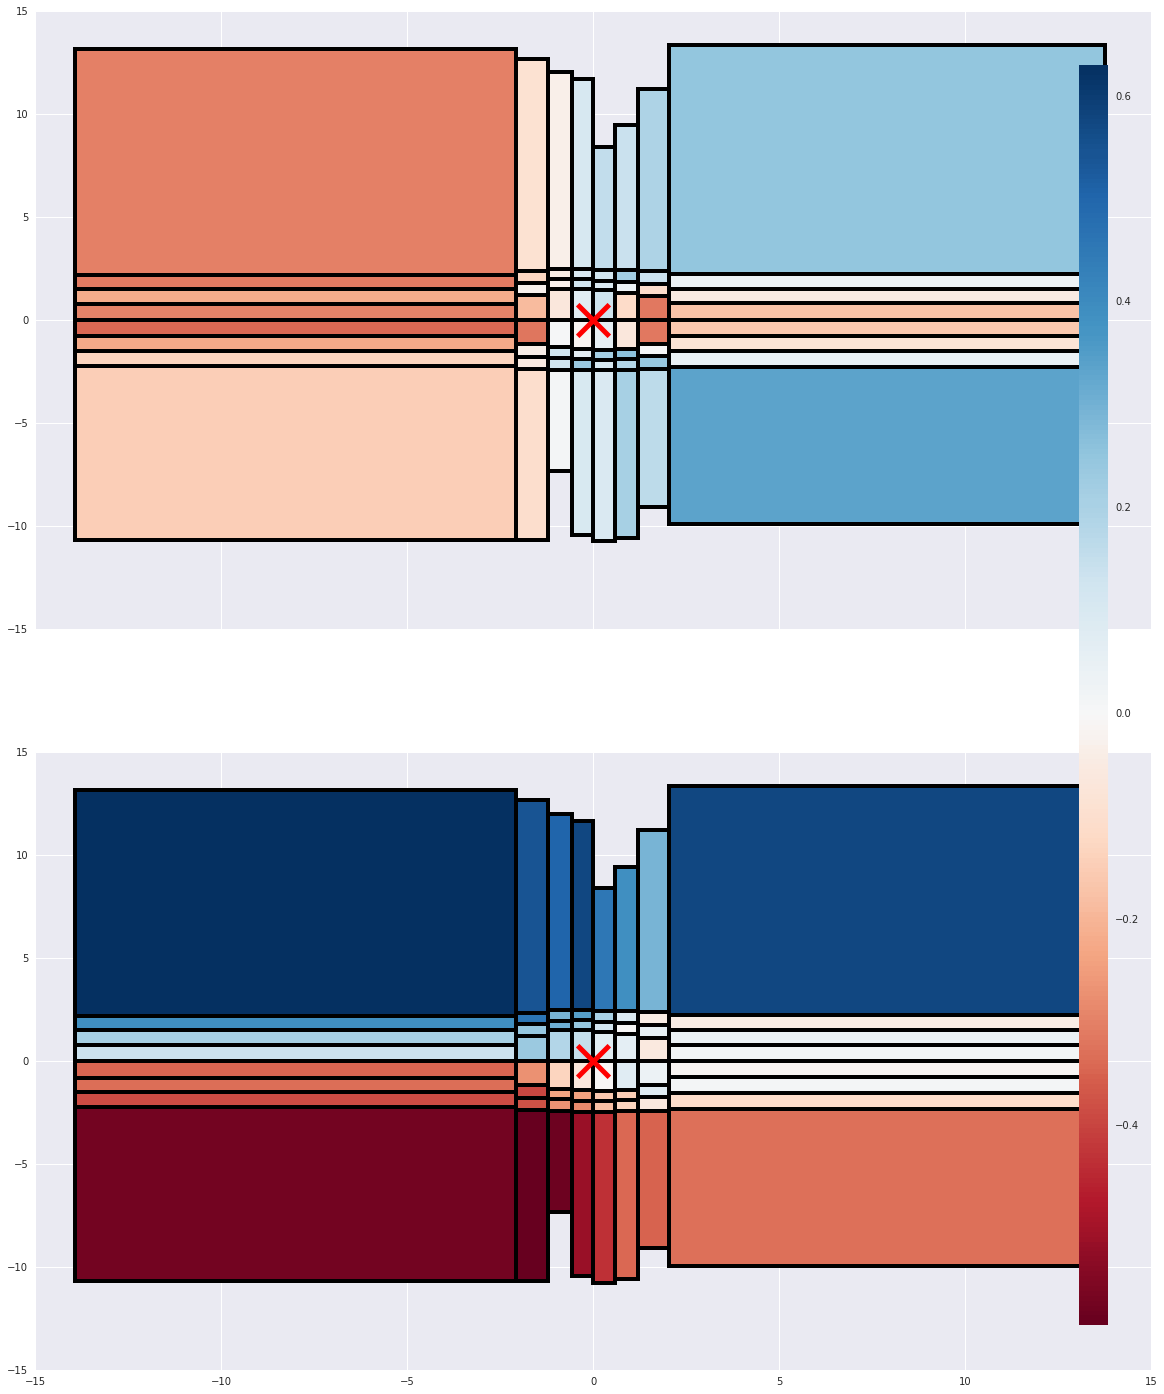

In [96]:
#bins = np.unique(df_train.loc[df_train['dt']==0,'bin'])
# id = (bin_x*len(bins)) + bin_y
coords = np.array([(b//num_bins) for b in bins])

#nn_coef = model.linear.weight.data.cpu().numpy()

spatial = linear.coef_[:,0:num_bins**2]
angular = linear.coef_[:,num_bins**2:]

#bins.shape, spatial.shape
#spatial_weights = np.zeros((num_bins*num_bins))
spatial_weights = spatial.reshape(2,num_bins,num_bins)
#spatial_weights = spatial_weights.reshape(num_bins,num_bins)

angular_weights = angular.reshape(2,num_bins,num_bins, 2)

vmin = min(spatial_weights.min(), angular_weights.min())
vmax = max(spatial_weights.max(), angular_weights.max())

coef = linear.coef_
#spatial_weights = coef[:num_bins**2]
#angular_weights = coef[num_bins**2:]

weights_range = coef.min(), coef.max()

fig, ax = plt.subplots(2, figsize=(20,25), sharex=True)
_ = plot_bins(edges_x, edges_y, spatial_weights[0,:].reshape(-1), fig=fig, ax=ax[0], weights_range=weights_range)
mapper = plot_bins(edges_x, edges_y, spatial_weights[1,:].reshape(-1), fig=fig, ax=ax[1], weights_range=weights_range)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(mapper, cax=cbar_ax)